<a href="https://colab.research.google.com/github/andreacangiani/NMPDE2025/blob/main/python/CP2_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Divided differences using sparse matrix

Import the usual modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

New module: sparse algebra

In [2]:
import scipy.sparse as sp

Function implementing the forward difference in sparse format

In [3]:
def forw_diff(N):
  # Compute FD matrix in spare fom using Compressed Sparse Row (CSR) format
  data=[-np.ones(N+1), np.ones(N)]
  return sp.diags(data,[0,1], format="csr")


In [4]:
help(sp.diags)

Help on function diags in module scipy.sparse._construct:

diags(diagonals, offsets=0, shape=None, format=None, dtype=None)
    Construct a sparse matrix from diagonals.
    
    .. warning::
    
        This function returns a sparse matrix -- not a sparse array.
        You are encouraged to use ``diags_array`` to take advantage
        of the sparse array functionality.
    
    Parameters
    ----------
    diagonals : sequence of array_like
        Sequence of arrays containing the matrix diagonals,
        corresponding to `offsets`.
    offsets : sequence of int or an int, optional
        Diagonals to set (repeated offsets are not allowed):
          - k = 0  the main diagonal (default)
          - k > 0  the kth upper diagonal
          - k < 0  the kth lower diagonal
    shape : tuple of int, optional
        Shape of the result. If omitted, a square matrix large enough
        to contain the diagonals is returned.
    format : {"dia", "csr", "csc", "lil", ...}, optional
   

Exmaple of Forward Difference matrix

In [5]:
# Fix a grid
a=0
b=1
N=5
h=(b-a)/N
D=forw_diff(N)/h


In [6]:
print(D)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 11 stored elements and shape (6, 6)>
  Coords	Values
  (0, 0)	-5.0
  (0, 1)	5.0
  (1, 1)	-5.0
  (1, 2)	5.0
  (2, 2)	-5.0
  (2, 3)	5.0
  (3, 3)	-5.0
  (3, 4)	5.0
  (4, 4)	-5.0
  (4, 5)	5.0
  (5, 5)	-5.0


In [7]:
print(D.todense())

[[-5.  5.  0.  0.  0.  0.]
 [ 0. -5.  5.  0.  0.  0.]
 [ 0.  0. -5.  5.  0.  0.]
 [ 0.  0.  0. -5.  5.  0.]
 [ 0.  0.  0.  0. -5.  5.]
 [ 0.  0.  0.  0.  0. -5.]]


Test: use the FD to evaluate the derivative of $f(x)=\frac{x^2}{2}$

In [8]:
# Fix function f using symbolic tool
t = sym.var('t')
fsym = 0.5 * t**2
# Define the function as an inline function
f = sym.lambdify(t, fsym )

# Set up interval and cardinality of the grid
a=0
b=1
N=50
h=(b-a)/N

# set up grid points
x = np.linspace(a,b,N+1)

# Evaluate FD matrix
D=forw_diff(N)/h

# Values of the derivative at the grid points
uh = D.dot(f(x))[1:N]

# Print results
#print(uh)

Compute max error

In [9]:
fdsym = fsym.diff(t,1)
fd = sym.lambdify(t,fdsym)

print(max(abs(uh-fd(x[1:N]))))

0.010000000000003229


**Exercise 1.** Find a way to evaluate execution time and compare full vs sparse exectution time in function of the grid size N.

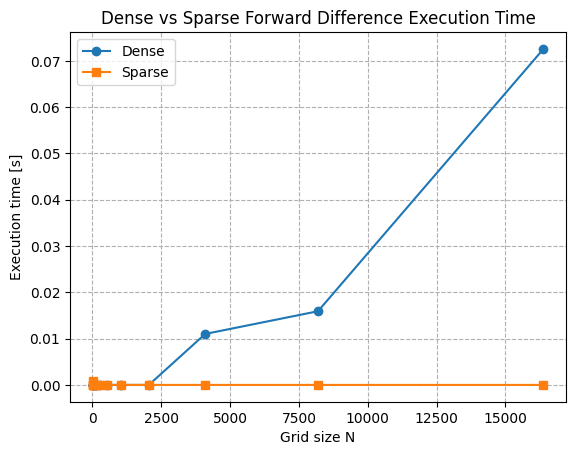

In [10]:
import time

def forw_diff(N):
    data = [-np.ones(N+1), np.ones(N)]
    return sp.diags(data, [0, 1], format="csr")

def forw_diff_dense(N):
    D = np.zeros((N+1, N+1))
    for i in range(N):
        D[i, i] = -1
        D[i, i+1] = 1
    return D

t = sym.var('t')
fsym = 0.5 * t**2
fdsym = fsym.diff(t, 1)
f = sym.lambdify(t, fsym)
fd = sym.lambdify(t, fdsym)

a, b = 0, 1
n_exp = 15
N_values = [2**N for N in range(2, n_exp)]
time_sparse = []
time_dense = []

for N in N_values:
    h = (b - a) / N
    x = np.linspace(a, b, N+1)
    fx = f(x)
    
    D_sparse = forw_diff(N) / h
    start = time.time()
    uh_sparse = D_sparse.dot(fx)[1:N]
    end = time.time()
    time_sparse.append(end - start)
    
    D_dense = forw_diff_dense(N) / h
    start = time.time()
    uh_dense = D_dense.dot(fx)[1:N]
    end = time.time()
    time_dense.append(end - start)

plt.plot(N_values, time_dense, 'o-', label='Dense')
plt.plot(N_values, time_sparse, 's-', label='Sparse')
plt.xlabel('Grid size N')
plt.ylabel('Execution time [s]')
plt.title('Dense vs Sparse Forward Difference Execution Time')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


# Finite Differences for two-points boundary value problems with constant coefficients

Poisson problem in 1D:

$-u''(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$

We use the second central divided difference to approxima the second derivative.

Given $h>0$,

$u''(x)≈\frac{u(x+h)-2u(x)+u(x-h)}{h^2}$

Function for second central matrix

In [11]:
def CD2(N):
  # Function defining nominator of
  # second central FD formula on a
  # uniform grid in sparse CSR format
  data = [np.ones(N), -2*np.ones(N+1), np.ones(N)]
  return sp.diags(data,[-1,0,1], format="csr")


Example of second central matrix.

In [12]:
N=5
A = CD2(N)

#print(cent_diff)
print(A.todense())

[[-2.  1.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  1. -2.]]


Test problem:

$(a,b)=(0,\pi)$

$u(x)=sin(x)$

In [13]:
# Define right-hand side function
t = sym.var('t')
fsym = sym.sin(t)
f = sym.lambdify(t, fsym )

# Define exact solution
usym = sym.sin(t)
u = sym.lambdify(t, fsym )

Define FD problem:

for $h=(b-a)/N$

$ A U = - h^2 F $

with $A$ the nominator of CD formula.

In [14]:
# Problem domain
a=0
b=np.pi

# Size of grid
N=200
h=(b-a)/N

# Grid
x=np.linspace(a,b,N+1)

# CD matrix
A=CD2(N)

# Right-hand side
F=-h**2*f(x[1:-1])

# Homogeneous Dirichlet boundary conditions
A = A[1:-1,1:-1]


Import solver

In [15]:
from scipy.sparse.linalg import spsolve

Solve problem and print result

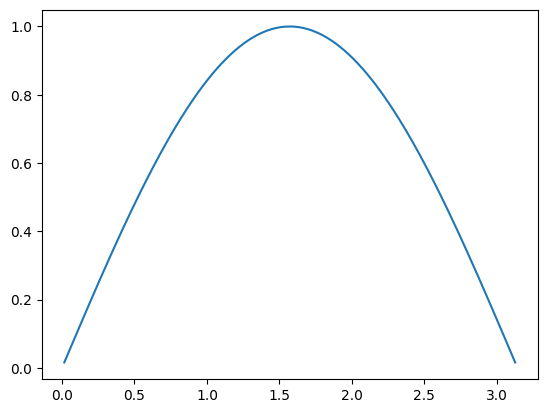

In [16]:
# Compute solution at internal nodes
uh = spsolve(A,F)
# plot solution
plt.plot(x[1:-1],uh)

In [17]:
# print max error

print(np.max(np.abs(uh-u(x[1:-1]))))

2.056192950417035e-05


**Exercise 2.** test for convergence and plot convergence plot

[8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
[1.29503847e-02 3.21895888e-03 8.03577593e-04 2.00821808e-04
 5.02009159e-05 1.25499455e-05 3.13746871e-06 7.84365686e-07
 1.96091983e-07 4.90272261e-08 1.22591346e-08 3.08253145e-09]


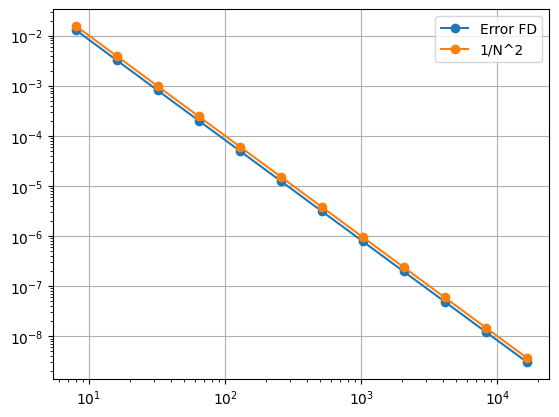

In [18]:
n_exp=15

nn=[]
error=[]

for i in range(3,n_exp):
    N=2**i
    h=(b-a)/N
    x=np.linspace(a,b,N+1)
    A=CD2(N)
    F=-h**2*f(x[1:-1])
    A = A[1:-1,1:-1]
    uh = spsolve(A,F)
    nn.append(N)
    error.append(np.max(np.abs(uh-u(x[1:-1]))))

print(nn)
print(f(error))
plt.loglog(nn, error,'o-', label="Error FD")
plt.loglog(nn, [n**(-2) for n in nn],'o-', label="1/N^2")
plt.legend()
plt.grid(True)
plt.show()
    

**Exercise 3.** Solve the problem with nonhomogeneous Dirichlet conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=\frac{1}{2}$

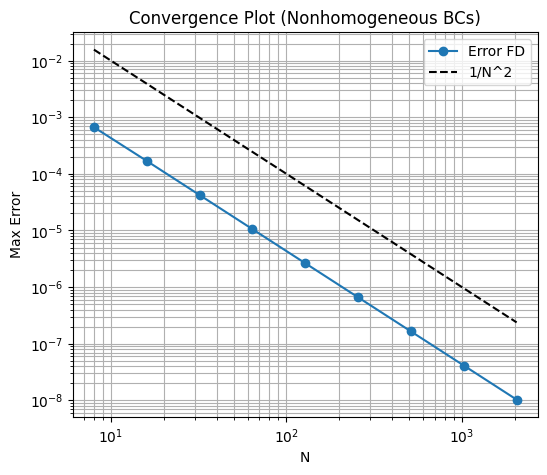

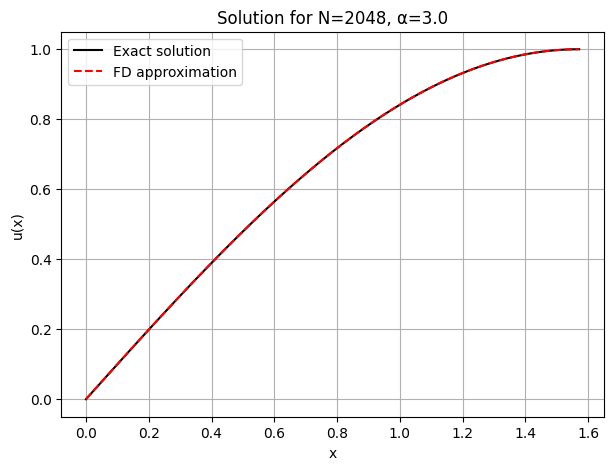

N=    8,  error=6.667e-04
N=   16,  error=1.692e-04
N=   32,  error=4.228e-05
N=   64,  error=1.057e-05
N=  128,  error=2.642e-06
N=  256,  error=6.605e-07
N=  512,  error=1.651e-07
N= 1024,  error=4.128e-08
N= 2048,  error=1.032e-08


In [3]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

def CD2(N):
    data = [np.ones(N), -2*np.ones(N+1), np.ones(N)]
    return sp.diags(data, [-1, 0, 1], format="csr")

a = 0
b = np.pi/2
alpha = 3.0                # diffusion coefficient
ua = 0.0             # u(a)
ub = 1.0             # u(b)

t = sym.Symbol('t', real=True)
usym = sym.sin(t)
fsym = alpha * (-usym.diff(t, 2))
u = sym.lambdify(t, usym)
f = sym.lambdify(t, fsym)

n_exp = 12
nn = []
error = []

for i in range(3, n_exp):
    N = 2**i
    h = (b - a) / N
    x = np.linspace(a, b, N+1)

    A = CD2(N)
    A = A[1:-1, 1:-1]
    F = -h**2 / alpha * f(x[1:-1])

    F[0]  -= ua
    F[-1] -= ub

    uh_inner = spsolve(A, F)

    uh = np.zeros_like(x)
    uh[0] = ua
    uh[-1] = ub
    uh[1:-1] = uh_inner

    err = np.max(np.abs(uh - u(x)))
    nn.append(N)
    error.append(err)

plt.figure(figsize=(6,5))
plt.loglog(nn, error, 'o-', label='Error FD')
plt.loglog(nn, [n**(-2) for n in nn], 'k--', label='1/N^2')
plt.xlabel('N')
plt.ylabel('Max Error')
plt.legend()
plt.grid(True, which='both')
plt.title('Convergence Plot (Nonhomogeneous BCs)')
plt.show()

N = nn[-1]
h = (b - a) / N
x = np.linspace(a, b, N+1)
A = CD2(N)
A = A[1:-1, 1:-1]
F = -h**2 / alpha * f(x[1:-1])
F[0]  -= ua
F[-1] -= ub
uh_inner = spsolve(A, F)
uh = np.zeros_like(x)
uh[0] = ua
uh[-1] = ub
uh[1:-1] = uh_inner

plt.figure(figsize=(7,5))
plt.plot(x, u(x), 'k-', label='Exact solution')
plt.plot(x, uh, 'r--', label='FD approximation')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.title(f'Solution for N={N}, α={alpha}')
plt.show()

# --- Print convergence data ---
for N, e in zip(nn, error):
    print(f"N={N:5d},  error={e:.3e}")


**Exercise 4.** Solve the problem with (homogeneous) Neumann conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u'(b)=0$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=1$.

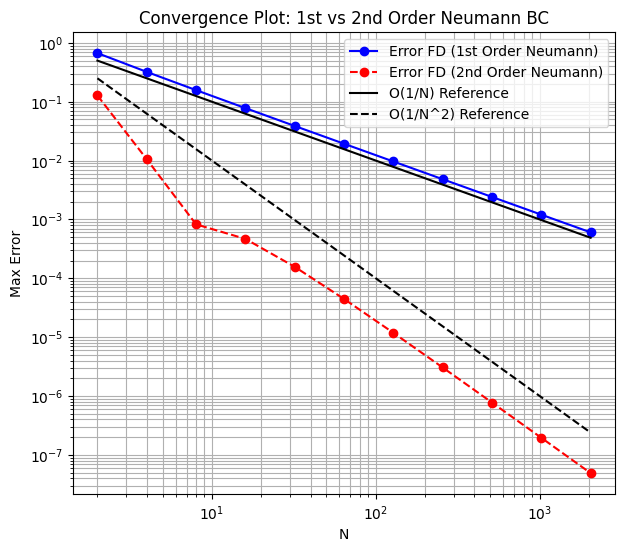

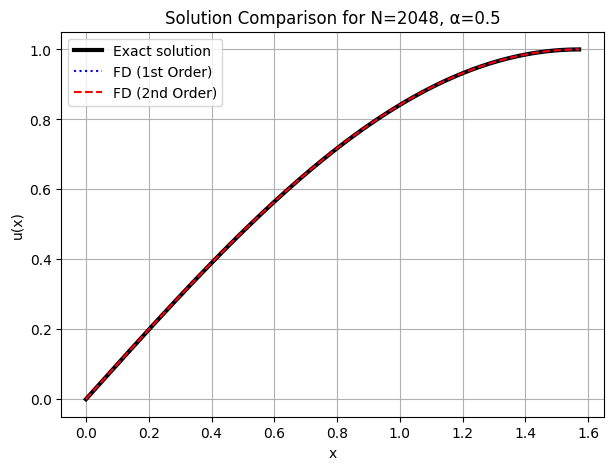

Convergence Data:
N   | Error (1st Order) | Error (2nd Order)
----|-------------------|-------------------
   2| 6.698796e-01        | 1.276420e-01
   4| 3.213759e-01        | 1.052672e-02
   8| 1.574315e-01        | 8.245016e-04
  16| 7.790986e-02        | 4.673045e-04
  32| 3.875396e-02        | 1.565629e-04
  64| 1.932677e-02        | 4.453130e-05
 128| 9.650835e-03        | 1.183271e-05
 256| 4.822280e-03        | 3.047281e-06
 512| 2.410356e-03        | 7.730587e-07
1024| 1.204982e-03        | 1.946768e-07
2048| 6.024419e-04        | 4.884955e-08


In [34]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

def CD2_DN1(N):
    data = [np.ones(N), -2*np.ones(N+1), np.ones(N)]
    A = sp.diags(data, [-1, 0, 1], format="lil")
    A[N, N] = -1
    A[N, N-1] = 1
    return A.tocsr()

def CD2_DN2(N):
    data = [np.ones(N), -2*np.ones(N+1), np.ones(N)]
    A = sp.diags(data, [-1, 0, 1], format="lil")
    A[N, :] = 0
    A[N, N] = 1
    A[N, N-1] = -4/3
    A[N, N-2] = 1/3
    return A.tocsr()

a = 0
b = np.pi/2
alpha = 0.5
ua = 0.0

t = sym.Symbol('t', real=True)
usym = sym.sin(t)
fsym = alpha * (-usym.diff(t, 2))
u = sym.lambdify(t, usym)
f = sym.lambdify(t, fsym)

n_exp = 12
nn = []
error1 = []
error2 = []

for i in range(1, n_exp):
    N = 2**i
    h = (b - a) / N
    x = np.linspace(a, b, N+1)
    
    # 1st Order Calculation
    A1 = CD2_DN1(N)
    A1_inner = A1[1:, 1:]
    F1 = -h**2 / alpha * f(x[1:])
    F1[0] -= ua
    
    uh1_inner = spsolve(A1_inner, F1)
    uh1 = np.zeros_like(x)
    uh1[0] = ua
    uh1[1:] = uh1_inner
    
    err1 = np.max(np.abs(uh1 - u(x)))
    error1.append(err1)
    
    # 2nd Order Calculation
    A2 = CD2_DN2(N)
    A2_inner = A2[1:, 1:]
    F2 = -h**2 / alpha * f(x[1:])
    F2[0] -= ua
    F2[-1] = 0.0
    
    uh2_inner = spsolve(A2_inner, F2)
    uh2 = np.zeros_like(x)
    uh2[0] = ua
    uh2[1:] = uh2_inner
    
    err2 = np.max(np.abs(uh2 - u(x)))
    error2.append(err2)
    
    nn.append(N)

plt.figure(figsize=(7, 6))
plt.loglog(nn, error1, 'o-', color='blue', label='Error FD (1st Order Neumann)')
plt.loglog(nn, error2, 'o--', color='red', label='Error FD (2nd Order Neumann)')
plt.loglog(nn, [n**(-1) for n in nn], 'k-', label='O(1/N) Reference')
plt.loglog(nn, [n**(-2) for n in nn], 'k--', label='O(1/N^2) Reference')
plt.xlabel('N')
plt.ylabel('Max Error')
plt.legend()
plt.grid(True, which='both')
plt.title('Convergence Plot: 1st vs 2nd Order Neumann BC')
plt.show()

N = nn[-1]
h = (b - a) / N
x = np.linspace(a, b, N+1)

A1 = CD2_DN1(N)
A1_inner = A1[1:, 1:]
F1 = -h**2 / alpha * f(x[1:])
F1[0] -= ua
uh1_inner = spsolve(A1_inner, F1)
uh1 = np.zeros_like(x)
uh1[0] = ua
uh1[1:] = uh1_inner

A2 = CD2_DN2(N)
A2_inner = A2[1:, 1:]
F2 = -h**2 / alpha * f(x[1:])
F2[0] -= ua
F2[-1] = 0.0
uh2_inner = spsolve(A2_inner, F2)
uh2 = np.zeros_like(x)
uh2[0] = ua
uh2[1:] = uh2_inner

plt.figure(figsize=(7, 5))
plt.plot(x, u(x), 'k-', linewidth=3, label='Exact solution')
plt.plot(x, uh1, 'b:', label='FD (1st Order)')
plt.plot(x, uh2, 'r--', label='FD (2nd Order)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.title(f'Solution Comparison for N={N}, α={alpha}')
plt.show()

print("Convergence Data:")
print("N   | Error (1st Order) | Error (2nd Order)")
print("----|-------------------|-------------------")
for N, e1, e2 in zip(nn, error1, error2):
    print(f"{N:4d}| {e1:.6e}        | {e2:.6e}")

**Exercise 5.** Solve the reaction-advection-diffusion problem (still with central differences):

$-\alpha u''(x)+\beta u'(x)+\gamma u(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$


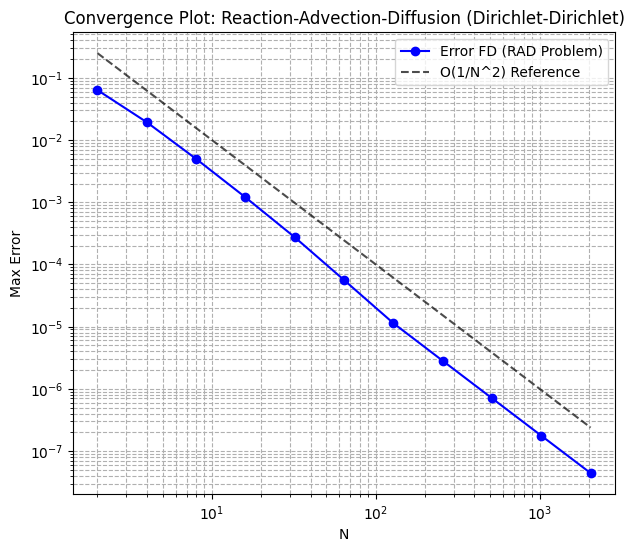

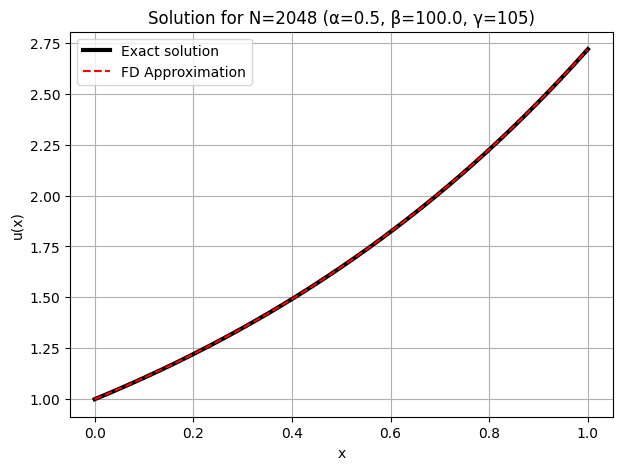

Convergence Data:
N   | Error (O(h^2))
----|-------------------
   2| 6.365815e-02
   4| 1.937576e-02
   8| 4.983947e-03
  16| 1.202109e-03
  32| 2.739643e-04
  64| 5.615898e-05
 128| 1.136502e-05
 256| 2.826287e-06
 512| 7.056390e-07
1024| 1.763575e-07
2048| 4.408890e-08


In [46]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

def CD2_RAD(N, h, alpha, beta, gamma):
    N_inner = N - 1
    
    Aii_diag = -2 * alpha - gamma * h**2
    Aii_sub = alpha + beta * h / 2
    Aii_sup = alpha - beta * h / 2
    
    data = [Aii_sub * np.ones(N_inner - 1), 
            Aii_diag * np.ones(N_inner), 
            Aii_sup * np.ones(N_inner - 1)]
    
    A = sp.diags(data, [-1, 0, 1], format="csr")
    
    return A

a = 0
b = 1
alpha = 0.5
beta = 100.0
gamma = 105
ua = 1.0
ub = np.exp(1)

t = sym.Symbol('t', real=True)
usym = sym.exp(t)

# f(x) = -alpha*u''(x) + beta*u'(x) + gamma*u(x)
u_prime_sym = usym.diff(t, 1)
u_double_prime_sym = usym.diff(t, 2)
fsym = -alpha * u_double_prime_sym + beta * u_prime_sym + gamma * usym

u = sym.lambdify(t, usym)
f = sym.lambdify(t, fsym)

n_exp = 12
nn = []
error = []

for i in range(1, n_exp):
    N = 2**i
    h = (b - a) / N
    x = np.linspace(a, b, N+1)
    
    A = CD2_RAD(N, h, alpha, beta, gamma)
    
    F = -h**2 * f(x[1:-1])
    
    Aii_sub = alpha + beta * h / 2
    Aii_sup = alpha - beta * h / 2
    
    F[0] -= Aii_sub * ua
    F[-1] -= Aii_sup * ub

    uh_inner = spsolve(A, F)

    uh = np.zeros_like(x)
    uh[0] = ua
    uh[-1] = ub
    uh[1:-1] = uh_inner

    err = np.max(np.abs(uh - u(x)))
    nn.append(N)
    error.append(err)

plt.figure(figsize=(7, 6))
plt.loglog(nn, error, 'o-', color='blue', label='Error FD (RAD Problem)')
plt.loglog(nn, [n**(-2) for n in nn], 'k--', alpha=0.7, label='O(1/N^2) Reference')
plt.xlabel('N')
plt.ylabel('Max Error')
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.title('Convergence Plot: Reaction-Advection-Diffusion (Dirichlet-Dirichlet)')
plt.show()

N_final = nn[-1]
h_final = (b - a) / N_final
x_final = np.linspace(a, b, N_final+1)

A_final = CD2_RAD(N_final, h_final, alpha, beta, gamma)
F_final = -h_final**2 * f(x_final[1:-1])

Aii_sub_final = alpha + beta * h_final / 2
Aii_sup_final = alpha - beta * h_final / 2

F_final[0] -= Aii_sub_final * ua
F_final[-1] -= Aii_sup_final * ub

uh_inner_final = spsolve(A_final, F_final)
uh_final = np.zeros_like(x_final)
uh_final[0] = ua
uh_final[-1] = ub
uh_final[1:-1] = uh_inner_final

plt.figure(figsize=(7, 5))
plt.plot(x_final, u(x_final), 'k-', linewidth=3, label='Exact solution')
plt.plot(x_final, uh_final, 'r--', label='FD Approximation')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.title(f'Solution for N={N_final} (α={alpha}, β={beta}, γ={gamma})')
plt.show()

print("Convergence Data:")
print("N   | Error (O(h^2))")
print("----|-------------------")
for N, e in zip(nn, error):
    print(f"{N:4d}| {e:.6e}")